In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE

pd.set_option('display.max_rows', 500)

## **1. Read the Data**

In [2]:
speed_agg = pd.read_csv("Dataset_cleaned/agg_jams_speed_Kota_Cimahi_clustering.csv")
speed_agg.shape

(27, 31)

In [3]:
speed_agg.head()

,street,Weekday_6,Weekday_7,Weekday_8,Weekday_9,Weekday_10,Weekday_11,Weekday_12,Weekday_13,Weekday_14,...,Weekend_11,Weekend_12,Weekend_13,Weekend_14,Weekend_15,Weekend_16,Weekend_17,Weekend_18,Weekend_19,Weekend_20
0,Gerbang Tol Pasteur 2,1.416419,0.698450,1.352741,1.155874,0.841060,2.012960,2.351831,1.950483,1.057126,...,2.542126,2.661304,2.983327,3.570918,2.274561,1.709907,2.584966,1.806230,1.567344,3.380854
1,Mahar Martanegara,-0.153285,-0.448483,0.000000,-0.367276,-0.162042,0.137770,-0.104619,-0.079209,-0.214221,...,-0.426226,-0.520847,-0.320392,0.391285,0.000000,-0.051771,-0.110619,-0.166919,-0.261399,-0.052792
2,N11 Jenderal Haji Amir Machmud,-0.439469,-0.713971,-0.474020,-0.819499,-0.534403,-0.580708,-0.549800,-0.665666,-0.664644,...,-0.935676,-1.057801,-0.979060,-1.103045,-0.837536,-0.878052,-0.710628,-0.619284,-0.091564,-0.157548
3,Jalan Gunung Batu,0.000000,0.403608,0.518056,0.001542,-0.150609,-0.008174,0.000000,0.212351,0.009109,...,0.094236,0.148003,0.014723,-0.172563,-0.051600,0.000000,-0.033502,-0.313475,-0.365763,-0.214854
4,Jenderal Gatot Subroto,0.129219,0.071971,0.427803,0.231585,1.554622,0.658961,0.084063,1.132302,0.238147,...,0.313228,0.798610,0.307703,0.522826,0.605517,0.495725,-0.009948,0.201655,0.875481,-0.359155


In [4]:
# Selecting dimensions for clustering
speed_num = speed_agg.iloc[:,1:]

# **2. Clustering**

## **A. KMeans wihtout Dimensionality Reduction**

For KMeans clustering we need to optimize the number of clusters (k), in this case we're using elbow method with inertia combined with silhouette method to decide k.

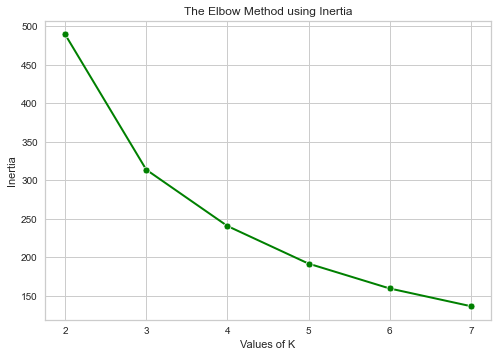

In [53]:
# Selecting optimal k with elbow method (inertia)
wss= []
k = []
for x in np.arange(2,8,1):
    k.append(x)
    kmeans = KMeans(n_clusters=x, init='k-means++', random_state=143)
    kmeans.fit(speed_num)
    wss.append(kmeans.inertia_)
    
sns.lineplot(x=k, y=wss, lw=2, marker='o', color='green')
plt.xlabel('Values of K'); plt.ylabel('Inertia'); plt.title('The Elbow Method using Inertia')
plt.show()

Text(0, 0.5, 'Silhouette Score')

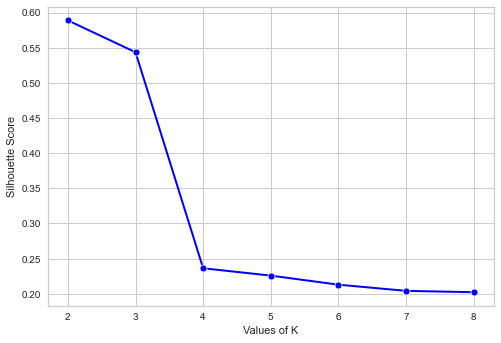

In [54]:
# Selecting optimal k with silhouette score
ss= []
k = []
for x in np.arange(2,9,1):
    k.append(x)
    kmeans = KMeans(n_clusters=x, init='k-means++', random_state=143)
    kmeans.fit(speed_num)
    ss.append(silhouette_score(speed_num, kmeans.labels_))
    
sns.lineplot(x=k, y=ss, lw=2, marker='o', color='blue')
plt.xlabel('Values of K'); plt.ylabel('Silhouette Score')

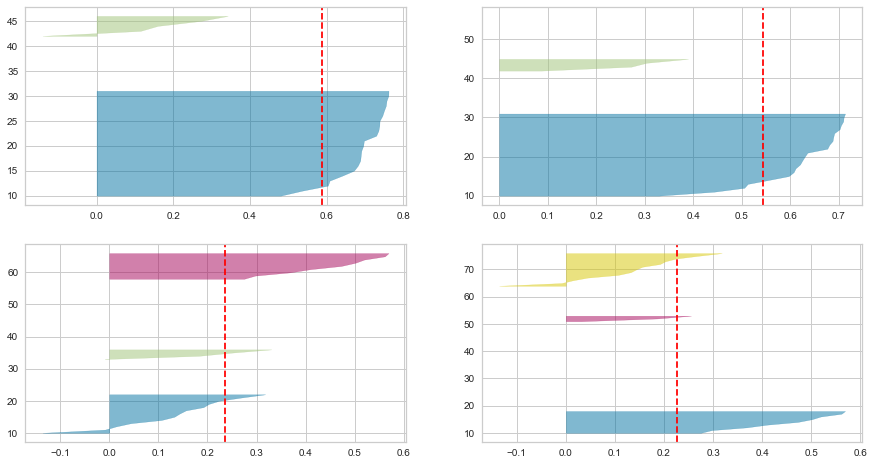

In [55]:
# Visualizing Silhouette
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=143)
    q, mod = divmod(i, 2)

    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(speed_num)

There doesn't seems to be a good pick for k when we didn't do any dimensionality reduction methods before clustering. So we can summarize that the raw data isn't well separated into groups in this higher dimension. Let's see if the clusters are better defined with dimensionality reduction techniques.

## **B. KMeans with Dimensionality Reduction (tSNE)**

We're going to use tSNE with n = 2, for perplexity I'll use an empirical formula from here : [link](https://towardsdatascience.com/how-to-tune-hyperparameters-of-tsne-7c0596a18868)

In [83]:
# Calculating perplexity
perp = np.round(np.exp(-0.179+0.51*np.log(speed_num.shape[0])), 1)
print(perp)

4.5


In [84]:
# Dimensionality Reduction with TSNE
t_sne = TSNE(n_components=2, learning_rate="auto", init="pca",
             perplexity=perp, n_iter=2000, random_state=143)
X_sne = t_sne.fit_transform(speed_num)
# Tabulating the results
speed_sne = pd.DataFrame(data=X_sne, columns=['tsne_1', 'tsne_2'])
speed_sne.shape

c:\Users\junio\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(27, 2)

<AxesSubplot:xlabel='tsne_1', ylabel='tsne_2'>

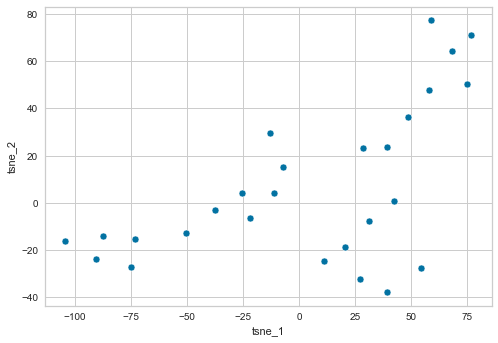

In [85]:
sns.scatterplot(data=speed_sne, x='tsne_1', y='tsne_2')

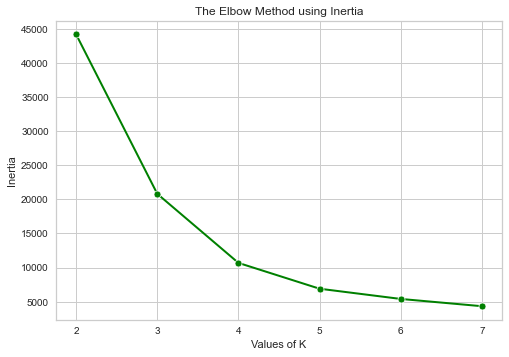

In [87]:
# Selecting optimal k with elbow method (inertia)
wss= []
k = []
for x in np.arange(2,8,1):
    k.append(x)
    kmeans = KMeans(n_clusters=x, init='k-means++', random_state=143)
    kmeans.fit(speed_sne)
    wss.append(kmeans.inertia_)
    
sns.lineplot(x=k, y=wss, lw=2, marker='o', color='green')
plt.xlabel('Values of K'); plt.ylabel('Inertia'); plt.title('The Elbow Method using Inertia')
plt.show()

Text(0, 0.5, 'Silhouette Score')

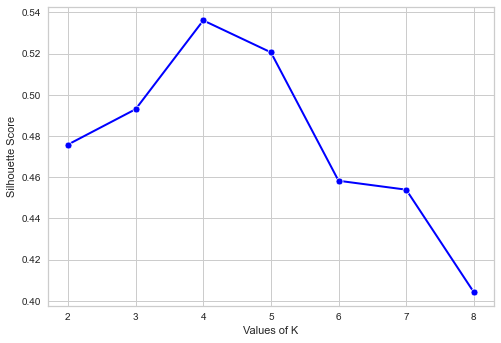

In [88]:
# Selecting optimal k with silhouette score
ss= []
k = []
for x in np.arange(2,9,1):
    k.append(x)
    kmeans = KMeans(n_clusters=x, init='k-means++', random_state=143)
    kmeans.fit(speed_sne)
    ss.append(silhouette_score(speed_sne, kmeans.labels_))
    
sns.lineplot(x=k, y=ss, lw=2, marker='o', color='blue')
plt.xlabel('Values of K'); plt.ylabel('Silhouette Score')

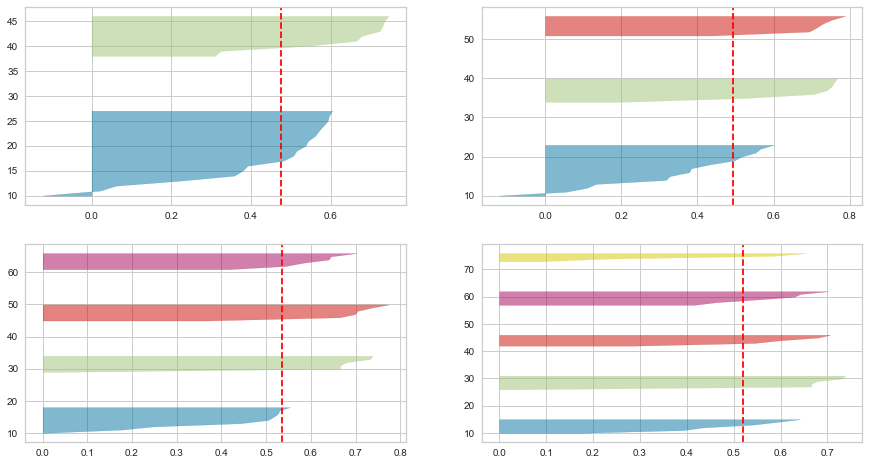

In [89]:
# Visualizing Silhouette
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=143)
    q, mod = divmod(i, 2)

    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(speed_sne)

Here we can see that dimensionality reduction with tSNE produce a better separation between clusters, and from their silhouette we can pick k=4 as the final number of clusters.

In [91]:
# Evaluation Metrics
kmeans_final = KMeans(n_clusters=4, init='k-means++', random_state=143)
kmeans_final.fit(speed_sne)
print("Optimized KMeans Inertia : ", kmeans_final.inertia_)
print("Optimized KMeans Silhouette Score : ", silhouette_score(speed_sne, kmeans_final.labels_) )

Optimized KMeans Inertia :  10682.330078125
Optimized KMeans Silhouette Score :  0.5360958


<AxesSubplot:xlabel='tsne_1', ylabel='tsne_2'>

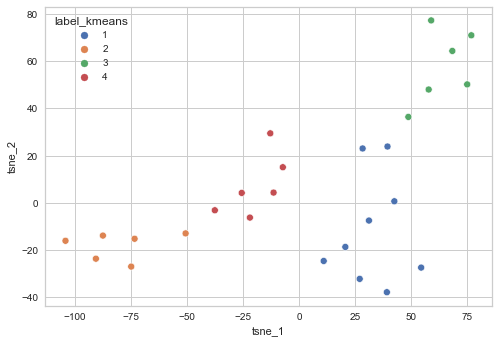

In [96]:
speed_sne['label_kmeans'] = kmeans_final.labels_+1
sns.scatterplot(data=speed_sne, x='tsne_1', y='tsne_2', hue='label_kmeans', palette="deep")

In [152]:
street_label = pd.DataFrame(speed_agg["street"])
street_label["label"] = kmeans_final.labels_+1
street_label.head()

,street,label
0,Gerbang Tol Pasteur 2,3
1,Mahar Martanegara,4
2,N11 Jenderal Haji Amir Machmud,2
3,Jalan Gunung Batu,1
4,Jenderal Gatot Subroto,1


In [154]:
# Exporting labeled dataset
# street_label.to_csv("Dataset_cleaned/street_Kota_Cimahi_labeled.csv",index = False)

### **BONUS : Comparison with DBSCAN**

In [104]:
# Determining 
nn = NearestNeighbors(n_neighbors=4).fit(speed_sne[["tsne_1", "tsne_2"]])
distances, indices = nn.kneighbors(speed_sne[["tsne_1", "tsne_2"]])

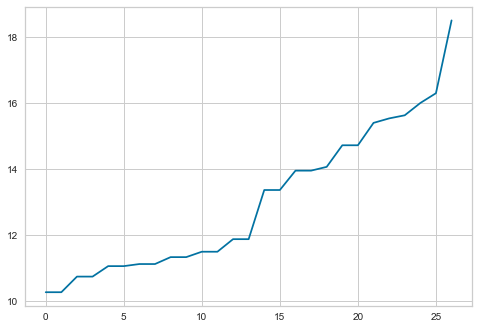

In [105]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [145]:
# We pick 17 as epsilon value from the distance plot
dbscan_final = DBSCAN(eps=18, min_samples=3)
dbscan_final.fit(speed_sne[["tsne_1", "tsne_2"]])

DBSCAN(eps=18, min_samples=3)

<AxesSubplot:xlabel='tsne_1', ylabel='tsne_2'>

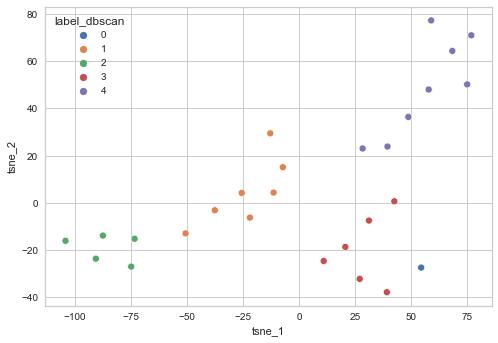

In [146]:
# Label = 0 means outliers
speed_sne['label_dbscan'] = dbscan_final.labels_+1
sns.scatterplot(data=speed_sne, x='tsne_1', y='tsne_2', hue='label_dbscan', palette="deep")

In [147]:
# Evaluation Metrics
print("Optimized KMeans Silhouette Score : ", silhouette_score(speed_sne[["tsne_1", "tsne_2"]], dbscan_final.labels_) )

Optimized KMeans Silhouette Score :  0.43529516
